# Weather prediction example

This notebook shows a way to forecast time series data using a PredictLite framework.

(c) Mikko Kursula 2022 - 2024. MIT License. 

In [1]:
# Enable automatic reloading (if changes are done in the model code)
%load_ext autoreload
%autoreload 2

# General
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Data source
import meteostat

# PredictLite
from predictlite.predictlite import PredictLite

### Get weather dataset

In [2]:
# Get hourly weather data for two different stations
stations = ['02944', '02763']
start_dt = datetime(2020, 1, 1)
end_dt = datetime(2024, 7, 1)
data = []
for station in stations:
    dataset = meteostat.Hourly(station, start_dt, end_dt).fetch()
    dataset['station'] = station
    data.append(dataset)

### Create categorical features

In [3]:
for i, station in enumerate(stations):
    data[i]['station'] = station # We use station as categorical feature
    data[i]['prcp'] = data[i]['prcp'].fillna(0)
    data[i]['prcp_cat'] = (data[i]['prcp'] > 0).astype(str)
    data[i]['wspd_cat'] = (data[i]['wspd'] > 5).astype(str)

### Setup and train PredictLite model 

In [9]:
model = PredictLite(
    input_signals=['temp', 'rhum'], 
    input_preprocessing={'temp' : 'z-norm', 'rhum' : 'z-norm'},
    datetime_embeddings=['month', 'hour'],
    datetime_embedding_dim=6,
    categorical_inputs=['wspd_cat', 'prcp_cat', 'station'],
    categorical_embedding_dim=4,
    input_length=72, 
    output_signals=['temp', 'rhum'],
    output_length=24,
    data_sample_period=3600,
    sequential_layer_neurons=[20],
    longitudinal_layer_neurons=[20],
    flattened_layer_neurons=[30, 30],
    percentiles=[0.25, 0.75],
    smoothing_weight=0.1
)

In [10]:
model.fit(
    data=data,
    train_sample_n=10000,
    test_sample_n=1000,
    epochs=20,
    learning_rate=0.0003,
    random_seed=13,
    verbose=True,
)

Setting up preprocessing
Building dataset
Training the model
epoch:   0, train loss: 0.98911, test loss: 0.72035
epoch:   1, train loss: 0.66034, test loss: 0.57818
epoch:   2, train loss: 0.54471, test loss: 0.46558
epoch:   3, train loss: 0.46100, test loss: 0.41817
epoch:   4, train loss: 0.42979, test loss: 0.40929
epoch:   5, train loss: 0.42100, test loss: 0.40399
epoch:   6, train loss: 0.41543, test loss: 0.39512
epoch:   7, train loss: 0.41259, test loss: 0.39160
epoch:   8, train loss: 0.40921, test loss: 0.39159
epoch:   9, train loss: 0.40697, test loss: 0.39295
epoch:  10, train loss: 0.40494, test loss: 0.39406
epoch:  11, train loss: 0.40168, test loss: 0.38663
epoch:  12, train loss: 0.40029, test loss: 0.38850
epoch:  13, train loss: 0.39847, test loss: 0.38265
epoch:  14, train loss: 0.39584, test loss: 0.38471
epoch:  15, train loss: 0.39542, test loss: 0.38377
epoch:  16, train loss: 0.39386, test loss: 0.38301
epoch:  17, train loss: 0.39206, test loss: 0.37841
epo

In [11]:
model.model_summary()

Inputs:
	Float inputs: ['temp', 'rhum']
	Time steps: 72
	month_emb: num_embeddings: 13, embedding_dim: 6
	hour_emb: num_embeddings: 25, embedding_dim: 6
	wspd_cat: num_embeddings: 3, embedding_dim: 4
	prcp_cat: num_embeddings: 3, embedding_dim: 4
	station: num_embeddings: 3, embedding_dim: 4
MLP sequential part:
	Linear(in_features=26, out_features=20, bias=True), parameter count: 540
	ReLU()
	Flatten(start_dim=-2, end_dim=-1)
MLP longitudinal part:
	Linear(in_features=72, out_features=20, bias=True), parameter count: 1460
	ReLU()
	Flatten(start_dim=-2, end_dim=-1)
MLP flattened part:
	Linear(in_features=1960, out_features=30, bias=True), parameter count: 58830
	ReLU()
	Linear(in_features=30, out_features=30, bias=True), parameter count: 930
	ReLU()
	Linear(in_features=30, out_features=144, bias=True), parameter count: 4464

Total MLP parameter count: 66224


### Make prediction

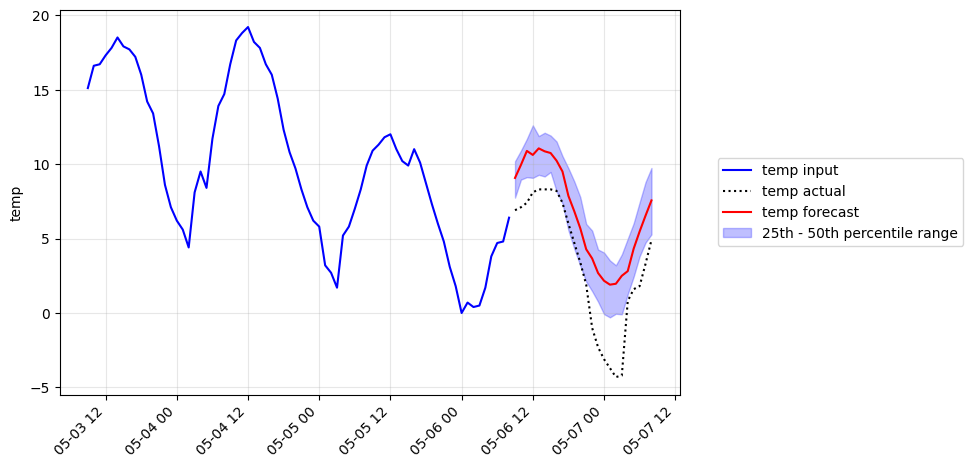

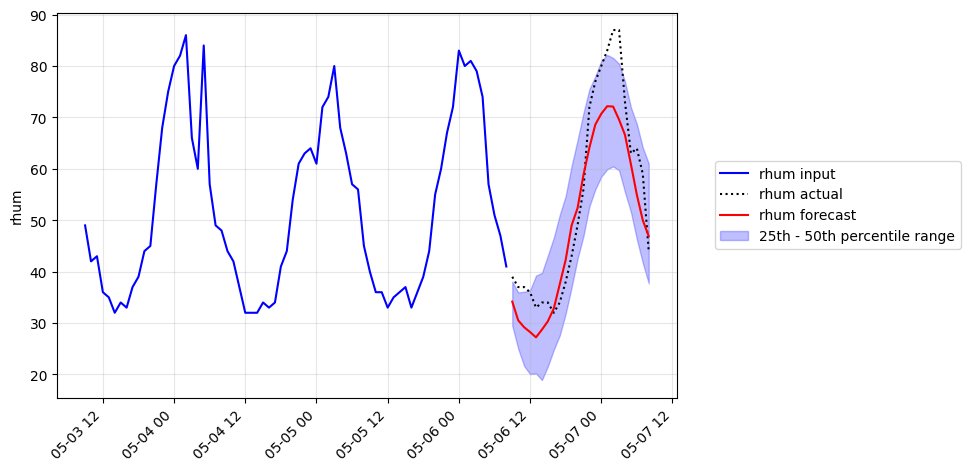

In [12]:
# Give datetime for prediction
prediction_time = datetime(2024, 5, 6, 8)

# Pick the dataset
df = data[0]

# Make prediction 
predictions = model.predict(df, prediction_time)

# Plot everything
for col in model.output_signals:
    ts_idx = dataset.index.get_indexer([prediction_time], method='pad')[0] + 1
    plt.figure(figsize=(8, 5))
    plt.plot(
        dataset.index[ts_idx - model.input_length : ts_idx].values, 
        dataset.iloc[ts_idx - model.input_length : ts_idx][col].values, 
        color='blue', 
        label='{} input'.format(col)
    )
    plt.plot(
        dataset.index[ts_idx : ts_idx + model.output_length].values, 
        dataset.iloc[ts_idx : ts_idx + model.output_length][col].values, 
        color='black',
        ls=':',
        label='{} actual'.format(col)
    )
    plt.plot(
        predictions['prediction'].index.values, 
        predictions['prediction'][col].values, 
        color='red', 
        label='{} forecast'.format(col)
    )
    plt.fill_between(
        predictions['lower_percentile'].index.values, 
        y1=predictions['lower_percentile'][col].values, 
        y2=predictions['upper_percentile'][col].values,
        color='blue', 
        alpha=0.25,
        label='25th - 50th percentile range'
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(col)
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.grid(alpha=0.3)
    plt.show()